In [1]:
# Imports
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset, TensorDataset

from torchsummary import summary
import torchvision as tv
import torchvision.transforms as T
import copy

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###

# Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Pytorch Gpu Configuration for directml(AMD GPU)
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)


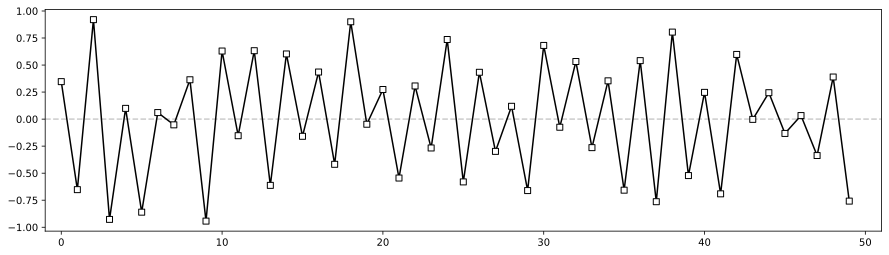

torch.Size([50])

In [7]:
## Create temporal sequence data
# Import the data
N = 50

data = torch.zeros(N)

for i in range(N):
    data[i] = torch.rand(1) * (-1) ** i

plt.figure(figsize=(15, 4))
plt.plot([-1, N + 1], [0, 0], "--", color=[0.8, 0.8, 0.8])
plt.plot(data.cpu(), "ks-", markerfacecolor="w")
plt.xlim([-1, N + 1])
plt.show()
data.shape


In [8]:
## Create a class for the RNN DL model
class rnnnet(nn.Module):
    def __init__(self, input_size, num_hidden, num_layers):
        super().__init__()
        print(f'Input Size: {input_size}, Hidden Layers: {num_hidden}, Number of Layers: {num_layers}')
        # RNN Layers
        self.rnn = nn.RNN(input_size, num_hidden, num_layers)

        # Linear layer for output
        self.out = nn.Linear(num_hidden, 1)

    def forward(self, x):
        # Run through the RNN Layer
        y, hidden = self.rnn(x) # There will be no explicit hidden state initialization

        # And the output (linear) layer
        y = self.out(y)

        return y, hidden


In [10]:
# Network parameters
input_size = 1 # Channels of data
num_hidden = 5 # Breadth of model (Number of units in hidden layers)
num_layers = 1 # Depth of model (number of stacks of hidden layers)
seqlength = 9 # Number of datapoints used for learning in each segments
batchsize = 1 # Note: The training code is actually hard coded to organize data into batchsize=1

# Create an instance of the model
net = rnnnet(input_size, num_hidden, num_layers)
X = torch.rand(seqlength, batchsize, input_size)
y, h = net(X)
print('X shape: ', X.shape)
print(
    'y Shape: ', y.shape
)  # note: one output per sequence element; generally, we take the final output to force a "many-to-one" design.
print('h shape: ', h.shape)


Input Size: 1, Hidden Layers: 5, Number of Layers: 1
X shape:  torch.Size([9, 1, 1])
y Shape:  torch.Size([9, 1, 1])
h shape:  torch.Size([1, 1, 5])


In [14]:
# test the model with some data
somedata = data[:seqlength].view(seqlength, 1, 1)
print(somedata.shape)
y = net(somedata)

# grab the final predicted value from the output (first element of tuple output of net)
finalValue = y[0][-1]
print(f'Final value: {finalValue}')

lossfun = nn.MSELoss()
loss = lossfun(finalValue, data[seqlength].view(1, 1))
print(f'Loss: {loss}')


torch.Size([9, 1, 1])
Final value: tensor([[0.1424]], device='cuda:0', grad_fn=<SelectBackward0>)
Loss: 1.1779580116271973


In [21]:
import sys
# Train the model and show performance
epochs = 30

# Create new instance of the model
net = rnnnet(input_size, num_hidden, num_layers)

optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

# Initialize losses
losses = np.zeros(epochs)
signAcc = np.zeros(epochs)

# Loop over epochs
for epoch in range(epochs):
    # Loop over data segments
    segLosses = []
    segAcc = []
    hiddenState = torch.zeros(num_layers, batchsize, num_hidden)
    print(f'hidden state shape: {hiddenState}')

    for time in range(N-seqlength):
        # Grab a snippet of data
        X = data[time: time+seqlength].view(seqlength, 1, 1)
        y = data[time+seqlength].view(1, 1)

        # Forward pass and loss
        yHat, hiddenState = net(X)
        finalValue = yHat[-1]
        loss = lossfun(finalValue, y) # Compare final value of output

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Loss from this segment
        segLosses.append(loss.cpu().item())

        # Also get the sigh accuracy
        trueSign = np.sign(torch.squeeze(y).cpu().numpy())
        predSign = np.sign(torch.squeeze(finalValue).cpu().detach().numpy())
        accuracy = 100 * (trueSign == predSign)
        segAcc.append(accuracy)

    # Average losses from this epoch
    losses[epoch] = np.mean(segLosses)
    signAcc[epoch] = np.mean(segAcc)

    msg = f'Finished epoch {epoch + 1} / {epochs}'
    sys.stdout.write('\r' + msg + '\n')


Input Size: 1, Hidden Layers: 5, Number of Layers: 1
hidden state shape: tensor([[[0., 0., 0., 0., 0.]]], device='cuda:0')
Finished epoch 1 / 30
hidden state shape: tensor([[[0., 0., 0., 0., 0.]]], device='cuda:0')
Finished epoch 2 / 30
hidden state shape: tensor([[[0., 0., 0., 0., 0.]]], device='cuda:0')
Finished epoch 3 / 30
hidden state shape: tensor([[[0., 0., 0., 0., 0.]]], device='cuda:0')
Finished epoch 4 / 30
hidden state shape: tensor([[[0., 0., 0., 0., 0.]]], device='cuda:0')
Finished epoch 5 / 30
hidden state shape: tensor([[[0., 0., 0., 0., 0.]]], device='cuda:0')
Finished epoch 6 / 30
hidden state shape: tensor([[[0., 0., 0., 0., 0.]]], device='cuda:0')
Finished epoch 7 / 30
hidden state shape: tensor([[[0., 0., 0., 0., 0.]]], device='cuda:0')
Finished epoch 8 / 30
hidden state shape: tensor([[[0., 0., 0., 0., 0.]]], device='cuda:0')
Finished epoch 9 / 30
hidden state shape: tensor([[[0., 0., 0., 0., 0.]]], device='cuda:0')
Finished epoch 10 / 30
hidden state shape: tensor

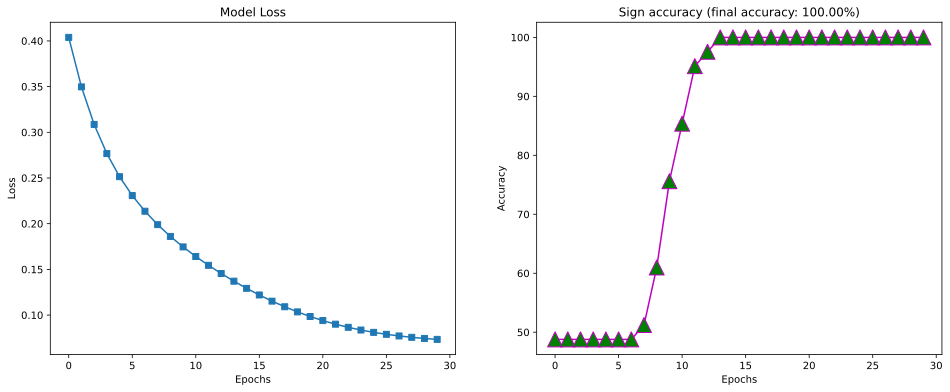

In [22]:
# Let's see how model did
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(losses, 's-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')

ax[1].plot(signAcc, 'm^-', markerfacecolor='g', markersize=15)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Sign accuracy (final accuracy: %.2f%%)" % signAcc[-1])

plt.show()
